<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/ToyGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Toy dataset

# Mount to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander


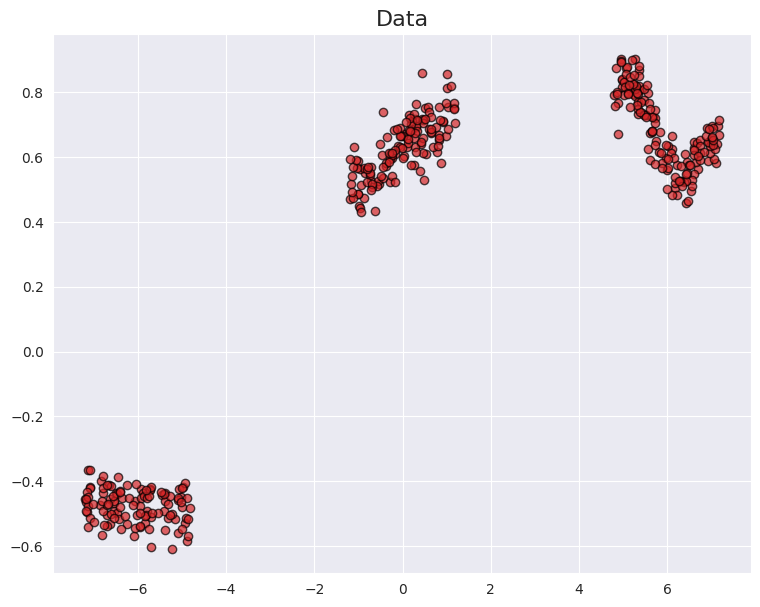

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander
----------------------------------------------------------
ALL MODELS: 
KISS-GP For 1D-4D data:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.ConstantMean()
      kernel = gpytorch.kernels.RBFKernel()
      model = KISSGP(x_train, y_train, likelihood, mean, kernel)
      model = model.to(device) # Move model to device

KISS-GP For higher dimensional data:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.ConstantMean()
      kernel = gpytorch.kernels.RBFKernel()
      model = KISSGP_NDim(x_train, y_train, likelihood, mean, kernel)
      model = model.to(device) # Move model to device

 Variational GP:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.Const

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#!pip install gpytorch > \dev\null # Suppress prints
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import jax
import jax.numpy as jnp
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "datasets/toy.ipynb" # Run the Toy notebook
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook

# Training Data from Toy

In [13]:
x_toy , y_toy = x, y # x, y are defined in ../datasets/Toy.ipynb
x_train_toy, x_test_toy, y_train_toy, y_test_toy = train_test_split(x_toy, y_toy, test_size=0.2, random_state=666)
# Transform into tensors
x_train_toy, x_test_toy, y_train_toy, y_test_toy = (
torch.from_numpy(x_train_toy), torch.from_numpy(x_test_toy),
torch.from_numpy(y_train_toy), torch.from_numpy(y_test_toy))

# Define the KISS-GP model

In [21]:
KISSGP_likelihood_toy = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_toy = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_toy = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_toy = KISSGP(x_train_toy, y_train_toy, KISSGP_likelihood_toy, KISSGP_mean_toy, KISSGP_kernel_toy) # KISSGP defined in utils/Models.ipynb

# Train the KISS-GP Model

4.990424394607544


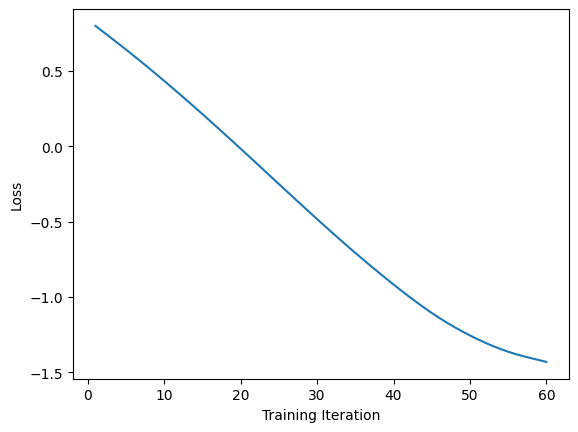

In [22]:
train_time_KISSGP_toy = train(KISSGP_model_toy, KISSGP_likelihood_toy, x_train_toy, y_train_toy, training_iter= 60) # train is defined in utils/functions.ipynb
print(train_time_KISSGP_toy)

# Predict with KISS-GP Model

In [23]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_toy = predict(KISSGP_model_toy, KISSGP_likelihood_toy, x_test_toy) # predict is defined in utils/functions.ipynb

# Evaluate Predictions

In [24]:
# Root Mean Square Error(RMSE)
RMSE_KISSGP_toy = mean_squared_error(y_test_toy, predictions_KISSGP_toy.mean, squared=False)
RMSE_KISSGP_toy

0.059337327853598194

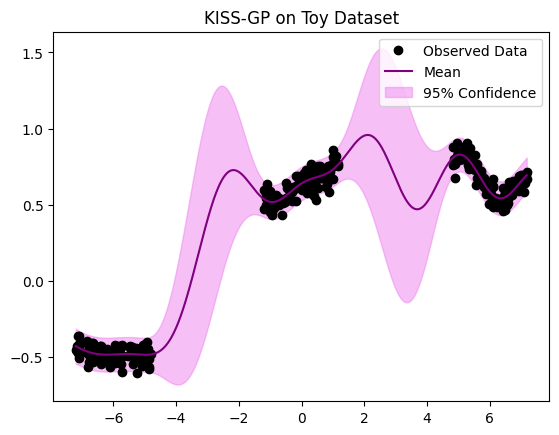

In [25]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_toy, y_train_toy, KISSGP_model_toy, KISSGP_likelihood_toy, "KISS-GP on Toy Dataset")

# Variational Model -------------------------------------------------------

In [32]:
variational_likelihood_toy = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_toy = gpytorch.means.ConstantMean()
variational_kernel_toy = gpytorch.kernels.RBFKernel()
n_inducing_points = 150
inducing_points = x_train_toy[torch.randperm(x_train_toy.size(0))[:n_inducing_points]]
variational_model_toy = variationalGP(variational_likelihood_toy, variational_mean_toy, variational_kernel_toy, inducing_points) # InducingGP defined in utils/models.ipynb
variational_model_toy = variational_model_toy.to(device) # Move model to device, defined in utils/models.ipynb

# Train the Variational model

Training Time:  1.9107484817504883


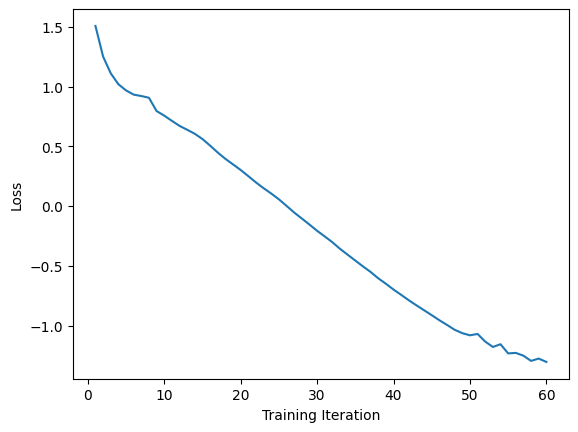

In [33]:
train_time_variational_toy = train_ELBO(variational_model_toy, variational_likelihood_toy, x_train_toy, y_train_toy, training_iter= 60) # train is defined in utils/functions.ipynb
print("Training Time: ",train_time_variational_toy)

# Predict With Variational Model

In [34]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_variational_toy = predict(variational_model_toy, variational_likelihood_toy, x_test_toy) # predict is defined in utils/functions.ipynb

# Evaluate Predictions

In [35]:
# Root Mean Square Error(RMSE)
RMSE_variational_toy = mean_squared_error(y_test_toy, predictions_variational_toy.mean, squared=False)
RMSE_variational_toy

0.06247392893645666

# Plot Variational Model

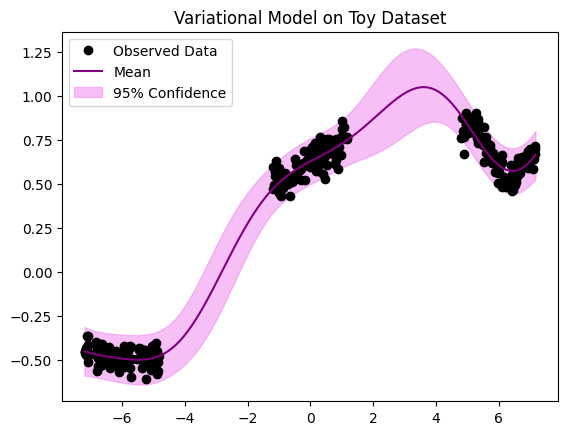

In [36]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_toy, y_train_toy, variational_model_toy, variational_likelihood_toy, "Variational Model on Toy Dataset")

# State Space Model

In [37]:
# To do the regression in state space, we need to rearrange the datapoints in temporal order
n_test_points = len(x_test_toy)
all_points = jnp.concatenate([x_train_toy.numpy(), x_test_toy.numpy()])
temporal_order = jnp.argsort(all_points)

# State Space X's and Y's
ss_xs_toy = all_points[temporal_order]
ss_ys_toy = jnp.concatenate([y_train_toy.numpy(), jnp.nan * jnp.ones((n_test_points, ))])[temporal_order]

# Compute the equivalent SS model
t0 = min(x_train_toy).numpy().item()
dts_toy = jnp.diff(ss_xs_toy, prepend=t0)

In [38]:
# Calculate ell and sigma
opt_ell_toy, opt_sigma_toy, train_time_SS_toy = train_SSGP(x_train_toy, y_train_toy, x_test_toy, ell=1, sigma=1)
print(train_time_SS_toy)

1.0093228816986084


In [39]:
mfs, vfs, mps, vps, _ = kalmanFilter(ss_ys_toy, dts_toy, opt_ell_toy, opt_sigma_toy, m0=0, v0=1)
mss, vss = kalmanSmoothing(opt_ell_toy, dts_toy, mfs, vfs, mps, vps)
ss_posterior_mean_toy = mss[jnp.isnan(ss_ys_toy)]
ss_posterior_var_toy = vss[jnp.isnan(ss_ys_toy)]

In [40]:
# Order y_test before calculating RMSE
temporal_order = jnp.argsort(x_test_toy.numpy())
y_temporal_order = y_test_toy.numpy()[temporal_order]
RMSE_SS_toy = mean_squared_error(y_temporal_order, ss_posterior_mean_toy, squared=False)
RMSE_SS_toy

0.07856985156925302

In [41]:
# Train with pytorch instead

# Calculate ell and sigma
opt_ell_toy_torch, opt_sigma_toy_torch, train_time_SS_toy_torch = train_SSGP_torch(x_train_toy, y_train_toy, x_test_toy, ell=1, sigma=1)
print("Training Time: ", train_time_SS_toy_torch)
print(opt_ell_toy_torch, opt_sigma_toy_torch)
# Convert them to numpy arrays
# Assume tensor is on GPU
opt_ell_toy_pytorch = opt_ell_toy_torch.to('cpu')
opt_sigma_toy_pytorch = opt_sigma_toy_torch.to('cpu')

opt_ell_toy_numpy = opt_ell_toy_pytorch.numpy()
opt_sigma_toy_numpy = opt_sigma_toy_pytorch.numpy()
# Calculate mean and variance
mfs_torch, vfs_torch, mps_torch, vps_torch, _ = kalmanFilter(ss_ys_toy, dts_toy, opt_ell_toy_numpy, opt_sigma_toy_numpy, m0=0, v0=1)
mss_torch, vss_torch = kalmanSmoothing(opt_ell_toy_numpy, dts_toy, mfs_torch, vfs_torch, mps_torch, vps_torch)
ss_posterior_mean_toy_torch = mss[jnp.isnan(ss_ys_toy)]
ss_posterior_var_toy_torch = vss[jnp.isnan(ss_ys_toy)]

# RMSE
RMSE_SS_toy_torch = mean_squared_error(y_temporal_order, ss_posterior_mean_toy_torch, squared=False)
print("RMSE: ",RMSE_SS_toy_torch)

Training Time:  0.354109525680542
tensor(1.3461) tensor(0.4952)
RMSE:  0.07856985156925302


# Plot State Space Model

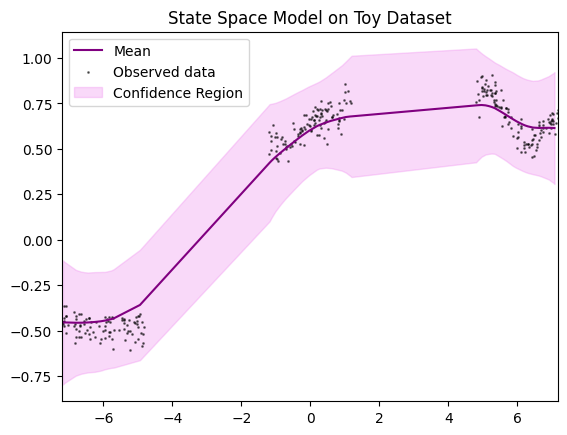

In [42]:
plot_SSGP(x_train_toy, y_train_toy, x_test_toy, ss_posterior_mean_toy, ss_posterior_var_toy, title= "State Space Model on Toy Dataset")

# State Space Model, without optimizer

In [43]:
# Pick hyperparameters on your own:
ell = 3
sigma = 1

start_time = time.time()
mfs2, vfs2, mps2, vps2, _ = kalmanFilter(ss_ys_toy, dts_toy, ell, sigma, m0=0, v0=1)
mss2, vss2 = kalmanSmoothing(ell, dts_toy, mfs2, vfs2, mps2, vps2)
ss_posterior_mean_toy2 = mss2[jnp.isnan(ss_ys_toy)]
ss_posterior_var_toy2 = vss2[jnp.isnan(ss_ys_toy)]
end_time = time.time()
time_SS2 = end_time-start_time
# RMSE
RMSE_SS_toy2 = mean_squared_error(y_temporal_order, ss_posterior_mean_toy2, squared=False)
RMSE_SS_toy2

0.05999762163478941

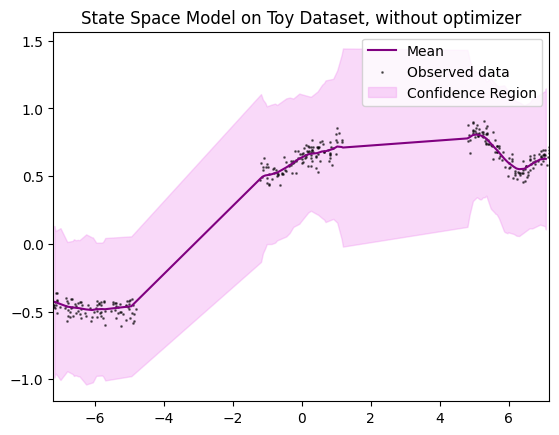

In [44]:
plot_SSGP(x_train_toy, y_train_toy, x_test_toy, ss_posterior_mean_toy2, ss_posterior_var_toy2, title= "State Space Model on Toy Dataset, without optimizer")

# Display Results

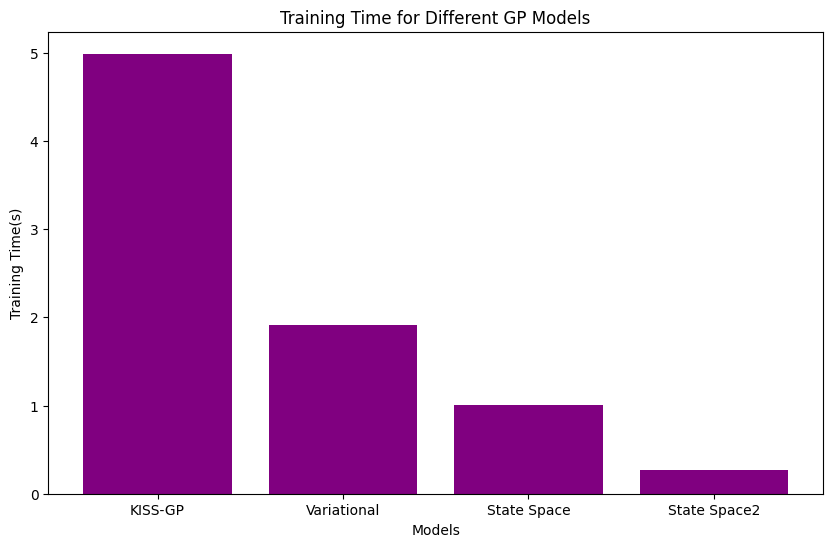

In [45]:
# Training times
models = ["KISS-GP", "Variational", "State Space", "State Space2"]
times_toy = [train_time_KISSGP_toy, train_time_variational_toy, train_time_SS_toy, time_SS2]
plot_bar(models, times_toy, "Training Time for Different GP Models", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

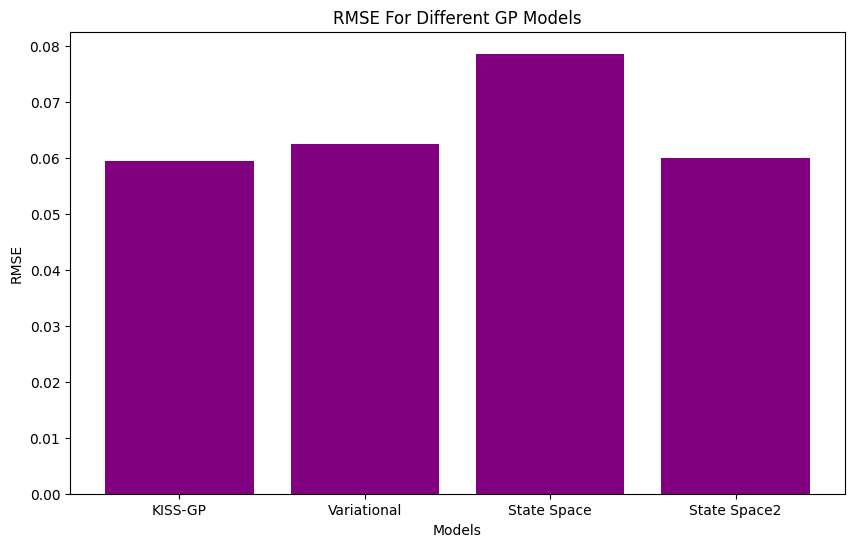

In [46]:
# RMSE
models = ["KISS-GP", "Variational", "State Space", "State Space2"]
RMSE_toy = [RMSE_KISSGP_toy, RMSE_variational_toy, RMSE_SS_toy, RMSE_SS_toy2]
plot_bar(models, RMSE_toy, "RMSE For Different GP Models", "Models", "RMSE") # plot_bar defined in utils/function.ipynb